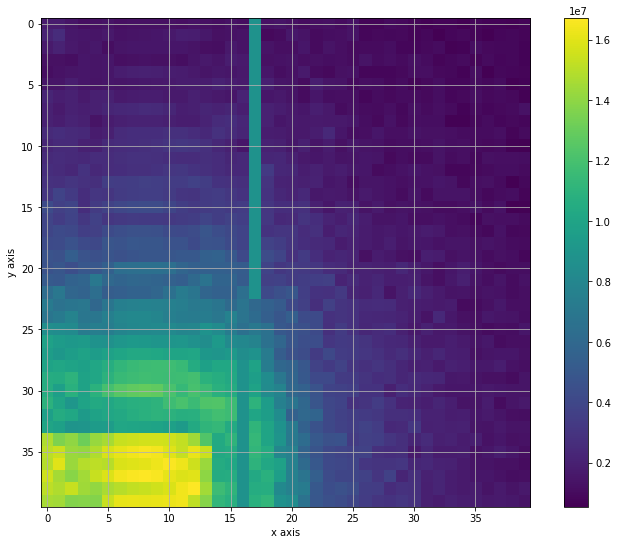

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from lmfit.models import QuadraticModel, LorentzianModel
import math

def findarg(data, value):
    arg = 0
    for wl in data:
        if wl<value:
            arg = arg + 1
        else:
            return arg
        
    return arg


data = pd.read_pickle('asher_20230603_hyperspec_EL2_98.pkl')

im = data['im']
wavel = data['wavelength']
map = np.sum(im, axis = 2)
# pixel numbers x and y
px = len(im)
py = len(im[0])
intensity = np.zeros((px,py))
#total intensity plot
plt.figure(figsize=(12,9))
plt.grid()
plt.imshow(map, cmap='viridis')
plt.colorbar()
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

In [2]:
def integrate (wavelength, intensity, minWavelength, maxWavelength):
    sum = 0
    Index = list(range(findarg(wavelength, minWavelength),findarg(wavelength, maxWavelength)))
    for i in Index:
        sum += intensity[i]*(wavelength[i+1]-wavelength[i])
    return sum

In [3]:
def getNvIntensity(data, regionx, regiony):
    currentPL = data['im'][regionx][regiony]
    model2 = QuadraticModel(prefix='bkg_') + LorentzianModel(prefix='nvm_')
    model = model2
    params = model.make_params()

    params['nvm_center'].set(value=638.8, min = 637.8, max = 639.8, vary=True)
    params['nvm_amplitude'].set(value=1000, vary=True)
    params['nvm_sigma'].set(value=2, max = 5, vary=True)

    params['bkg_a'].set(value = 0, vary=True)
    params['bkg_b'].set(value = 0, min = 0, vary=True)
    params['bkg_c'].set(value = 0, vary=True)

    Index = list(range(600,800))
    weightList = 1/np.sqrt(currentPL[Index])
    result = model.fit(currentPL[Index], params, x=wavel[Index], weights=weightList)
    comps = result.eval_components(x=wavel[Index])

    nvmCenter = result.params['nvm_center']
    nvmHWHM = result.params['nvm_sigma']
    return integrate(wavel[Index],comps['nvm_'],nvmCenter - nvmHWHM*2, nvmCenter + nvmHWHM*2)


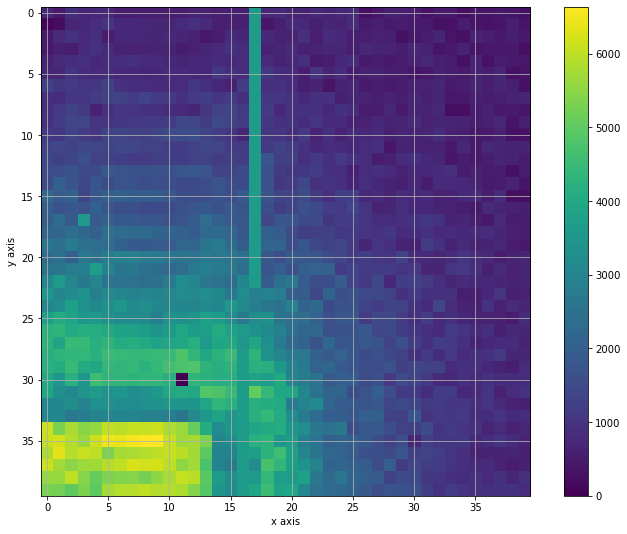

In [4]:
for i in range(px):
    for j in range(py):
        intensity[i][j] = getNvIntensity(data, i, j)
plt.figure(figsize=(12,9))
plt.grid()
plt.imshow(intensity, cmap='viridis')
plt.colorbar()
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()